# Importing modules and libraries

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from bnn_model import *
from gm_model import *
from empirica_model import *


import utils as ut
import edward as ed
from scipy.stats import norm
import tensorflow as tf

from sklearn import model_selection

import os, sys

# Basic data loading

In [2]:
df_12H = pd.read_csv("./env/data_frames/final_data_frame_12H.csv", sep=";", index_col="timestamp", parse_dates=True)
df_1H = pd.read_csv("./env/data_frames/final_data_frame_1H.csv", sep=";", index_col="timestamp", parse_dates=True)
df_1D = pd.read_csv("./env/data_frames/final_data_frame_1D.csv", sep=";", index_col="timestamp", parse_dates=True)

In [3]:
print(df_1D.values.shape)
print(df_12H.values.shape)
print(df_1H.values.shape)

(365, 38)
(730, 38)
(8760, 36)


In [5]:
P1_colmns_1D = list(filter(lambda col: "P1" in str(col),list(df_1D.columns.values)))
P2_colmns_1D = list(filter(lambda col: "P2" in str(col),list(df_1D.columns.values)))

P1_colmns_12H = list(filter(lambda col: "P1" in str(col),list(df_12H.columns.values)))
P2_colmns_12H = list(filter(lambda col: "P2" in str(col),list(df_12H.columns.values)))

P1_colmns_1H= list(filter(lambda col: "P1" in str(col),list(df_1H.columns.values)))
P2_colmns_1H = list(filter(lambda col: "P2" in str(col),list(df_1H.columns.values)))

np.array([P1_colmns_1D, P2_colmns_1D]).T

array([['P1_146', 'P2_146'],
       ['P1_309', 'P2_309'],
       ['P1_237', 'P2_237'],
       ['P1_422', 'P2_422'],
       ['P1_227', 'P2_227'],
       ['P1_219', 'P2_219'],
       ['P1_187', 'P2_187'],
       ['P1_295', 'P2_295'],
       ['P1_164', 'P2_164'],
       ['P1_140', 'P2_140'],
       ['P1_415', 'P2_415'],
       ['P1_191', 'P2_191'],
       ['P1_151', 'P2_151'],
       ['P1_286', 'P2_286'],
       ['P1_217', 'P2_217'],
       ['P1_466', 'P2_466'],
       ['P1_SAKP', 'P2_SAKP'],
       ['P1_SNTR', 'P2_SNTR'],
       ['P1_SBC', 'P2_SBC']], dtype='<U7')

In [5]:
X_1D = df_1D[P1_colmns_1D[0:-3]].values

y_SBC_1D_P1 = df_1D[P1_colmns_1D[-1]].values
y_SNTR_1D_P1 = df_1D[P1_colmns_1D[-2]].values

y_SBC_1D_P2 = df_1D[P2_colmns_1D[-1]].values
y_SNTR_1D_P2 = df_1D[P2_colmns_1D[-2]].values



X_1H = df_1H[P1_colmns_1H[0:-3]].values

y_SBC_1H_P1 = df_1H[P1_colmns_1H[-1]].values
y_SNTR_1H_P1 = df_1H[P1_colmns_1H[-2]].values

y_SBC_1H_P2 = df_1H[P2_colmns_1H[-1]].values
y_SNTR_1H_P2 = df_1H[P2_colmns_1H[-2]].values

X_12H = df_12H[P1_colmns_12H[0:-3]].values

y_SBC_12H_P1 = df_12H[P1_colmns_12H[-1]].values
y_SNTR_12H_P1 = df_12H[P1_colmns_12H[-2]].values

y_SBC_12H_P2 = df_12H[P2_colmns_12H[-1]].values
y_SNTR_12H_P2 = df_12H[P2_colmns_12H[-2]].values

In [6]:
def test_train_split(X, y, train_size=0.75, random=False):
    if random:
        return train_test_split(X, y, train_size=train_size, random_state=42)
    else:
        train_cnt = int(round(X.shape[0]*0.75, 0))
        return X[0:train_cnt], X[train_cnt:], y[0:train_cnt], y[train_cnt:]
    

def select_data(station, value, period):
    df = None
    if period == "1D":
        df = df_1D
    elif period == "12H":
        df = df_12H
    elif period == "1H":
        df = df_1H

    X, y = None, None
    if value == "P1":
        columns = list(filter(lambda col: "P1" in str(col),list(df.columns.values)))
    elif value == "P2":
        columns = list(filter(lambda col: "P2" in str(col),list(df.columns.values)))
    else:
        columns = list(filter(lambda col: "P2" in str(col) or "P1" in str(col),list(df.columns.values)))
        
    out_col = None
    if station == "SBC":
        out_col = -1
    else:
        out_col = -2

    y = df[columns[out_col]].values
    X = df[columns[0:-3]].values
    return X, y




# Basic data settings:

In [7]:
station = "SBC"
value="P1"
period="1D"
train_per = 0.75

# Test train split

In [8]:
X, y = select_data(station, value, period)
X_train, X_test, y_train, y_test = test_train_split(X, y,train_size=train_per)

y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(274, 16) (91, 16)
(274, 1) (91, 1)


# Bnn model definition

In [9]:
neurons_per_inner_bnn = 20
inner_layer_cnt_bnn = 2

layers = []
for i in range(inner_layer_cnt_bnn):
    layers.append(neurons_per_inner_bnn)


model_id = "bnn_n"+str(neurons_per_inner_bnn)+"_l"+str(inner_layer_cnt_bnn)+"_s"+str(station)+"_tts" + str(train_per) + "_v" + value + "_p" + period



print("Model id:" + model_id)
print("Layers:" + str(layers))




Model id:bnn_n20_l2_sSBC_tts0.75_vP1_p1D
Layers:[20, 20]


In [10]:
#model.load("./env/models/" + model_id +"/", model_id)
model = Bnn(model_id)
model.build(X_train.shape[1],1, layers)

Generating prior Variables
Generating latent Variables
Building Network for inference
Building Network for evaluation


In [11]:
batch_size_bnn = y_train.shape[0]
epochs_bnn = 10000
updates_per_batch_bnn = 2

In [12]:
model.fit(X_train, y_train, M=batch_size_bnn, updates_per_batch=updates_per_batch_bnn, epochs=epochs_bnn)

20000


In [14]:
#Some basic tests on the test set

In [16]:
#model.save("./env/models/" + model_id +"/", model_id)

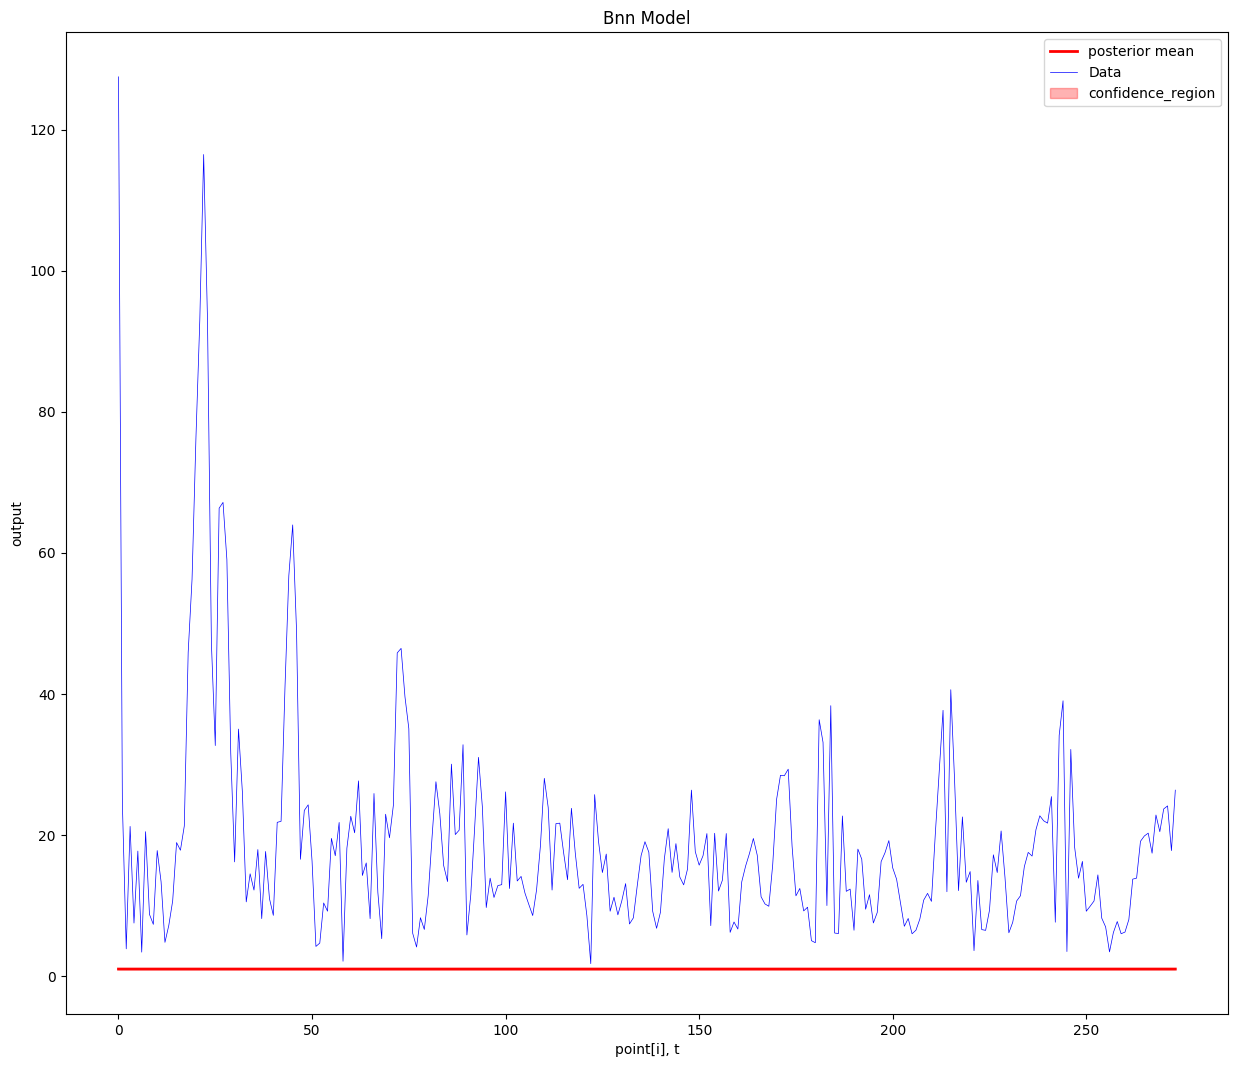

In [13]:
plt.figure(figsize=(15,13), dpi=100)


plt.title("Bnn Model")
plt.xlabel("point[i], t")
plt.ylabel("output")
    
samples = 100
outputs = model.evaluate(X_train, samples)
outputs = outputs.reshape(samples,X_train.shape[0])

line, = plt.plot(np.arange(len(outputs[0].reshape(-1))), np.mean(outputs, 0).reshape(-1),'r', lw=2, label="posterior mean")

plt.fill_between(np.arange(len(outputs[0].reshape(-1))),
                np.percentile(outputs, 5, axis=0),
                np.percentile(outputs, 95, axis=0),
                color=line.get_color(), alpha = 0.3, label="confidence_region")
    
plt.plot(np.arange(y_train.shape[0]) ,y_train, '-b' , linewidth=0.5,label='Data')


plt.legend()


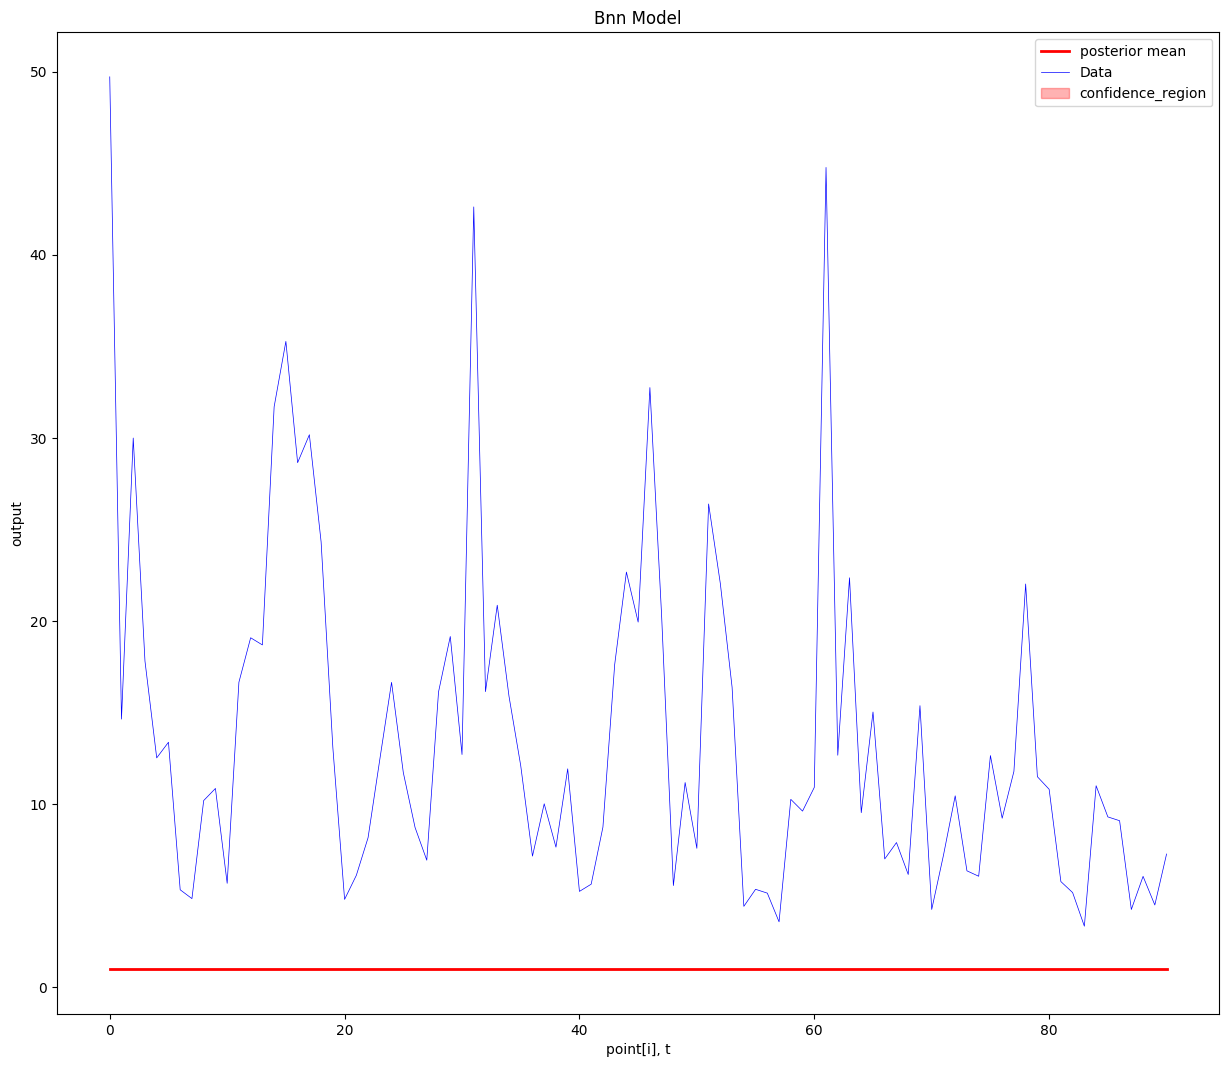

In [14]:
plt.figure(figsize=(15,13), dpi=100)


plt.title("Bnn Model")
plt.xlabel("point[i], t")
plt.ylabel("output")
    
samples = 100
outputs = model.evaluate(X_test, samples)
outputs = outputs.reshape(samples,X_test.shape[0])

line, = plt.plot(np.arange(len(outputs[0].reshape(-1))), np.mean(outputs, 0).reshape(-1),'r', lw=2, label="posterior mean")

plt.fill_between(np.arange(len(outputs[0].reshape(-1))),
                np.percentile(outputs, 5, axis=0),
                np.percentile(outputs, 95, axis=0),
                color=line.get_color(), alpha = 0.3, label="confidence_region")
    
    
    
plt.plot(np.arange(y_test.shape[0]) ,y_test, '-b' , linewidth=0.5,label='Data')


plt.legend()

In [16]:
neurons_per_inner_mdn = 5
inner_layer_cnt_mdn = 2
mixtures_cnt = 2

batch_size_mdn = 200
epochs_mdn = 1000
updates_per_batch_mdn = 5

layers_mdn = []
for i in range(inner_layer_cnt_mdn):
    layers.append(neurons_per_inner_mdn)

model_id = "mdn_n"+str(neurons_per_inner_mdn)+"_l"+str(inner_layer_cnt_mdn)+"_m"+str(mixtures_cnt)+"_s"+str(station)+"_tts" + str(train_per)



print("Model id:" + model_id)



Model id:mdn_n5_l2_m2_sSBC_tts0.75


In [17]:

#mdn_model = Mdn(model_id, X_train, y_train, inner_dims=layers_mdn, num_mixtures=mixtures_cnt)
#mdn_model = Mdn(model_id, X_train, y_train, inner_dims=layers_mdn, num_mixtures=mixtures_cnt,
                #model_file="sad")
#mdb_model.fit(num_iter=10000)

In [19]:



#mdn_model.save("./env/models/" + model_id +"/", model_id)

In [63]:
empirical_model = Emp("emp_"+"oP1_1D"+"_s"+str(station)+"_tts" + str(train_per))

samples=100
start_pos = int(round(y_SBC_1D_P1.shape[0]*train_per))
end_pos = y_SBC_1D_P1.shape[0]


res_1 = np.array([
        empirical_model.build(y_SBC_1D_P1[0:i]).evaluate(samples).reshape(samples)
        for i in range(start_pos,end_pos)
    ], dtype=np.float32)

In [64]:
mus_1 = res_1.mean(axis=1)
std_1 = res_1.std(axis=1)

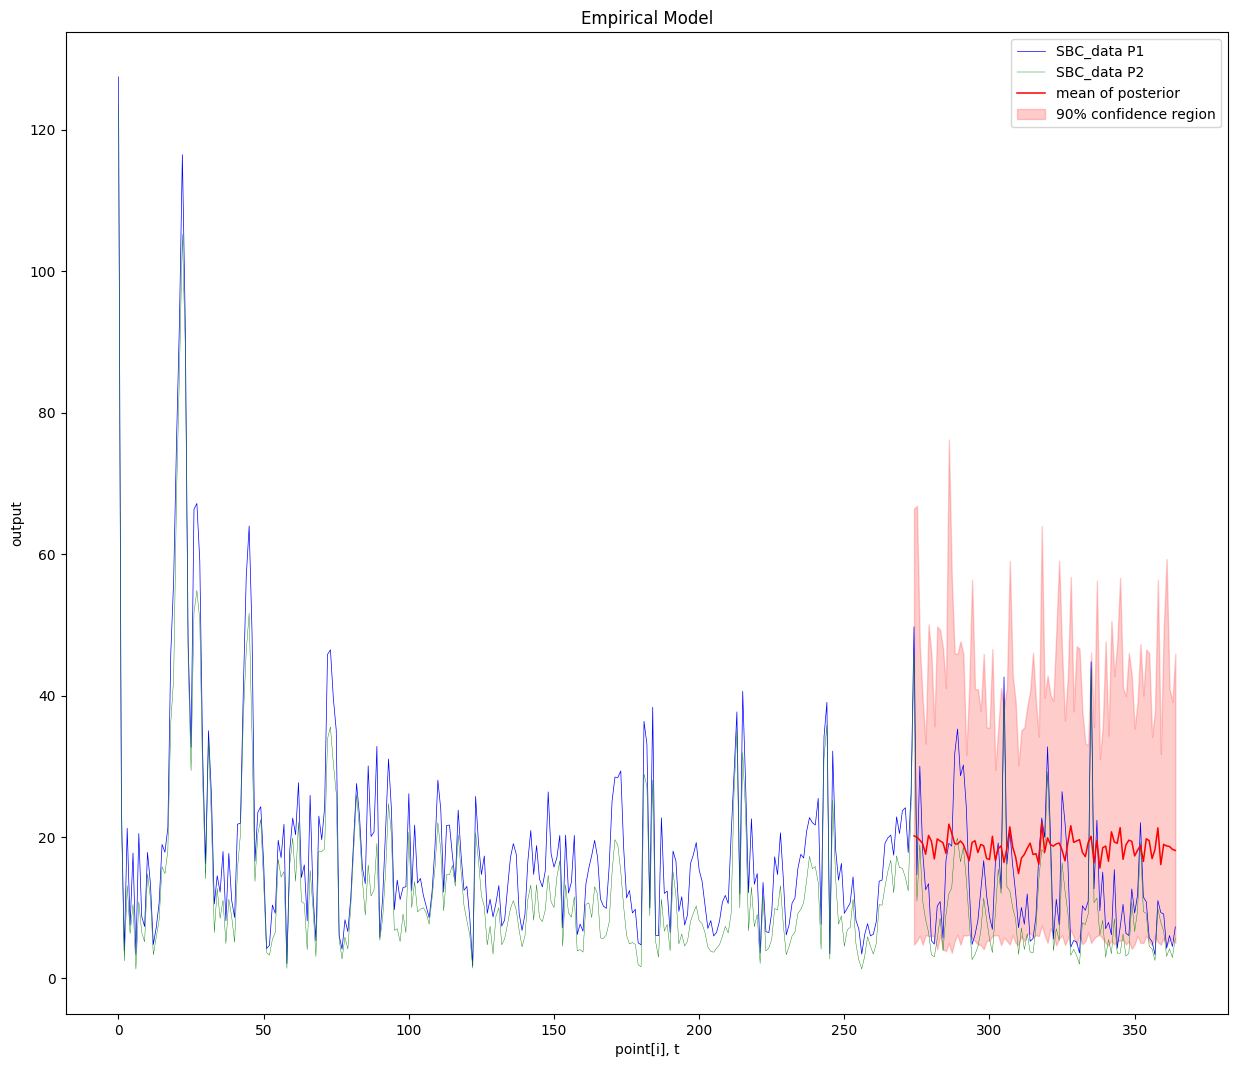

In [84]:
plt.figure(figsize=(15,13), dpi=100)


plt.title("Empirical Model")
plt.xlabel("point[i], t")
plt.ylabel("output")
    
plt.plot(np.arange(y_SBC_1D_P1.shape[0]) ,y_SBC_1D_P1, '-b' , linewidth=0.5,label='SBC_data P1')
plt.plot(np.arange(y_SBC_1D_P2.shape[0]) ,y_SBC_1D_P2, '-g' , linewidth=0.3,label='SBC_data P2')

plt.plot(np.arange(start_pos, end_pos) ,mus_1, '-r', linewidth=1.1, label='mean of posterior')
plt.fill_between(np.arange(start_pos, end_pos), np.percentile(res_1, 5, axis=1), np.percentile(res_1, 95, axis=1) , color="red", 
                 alpha=0.2,label="90% confidence region")

plt.legend()


In [66]:
empirical_model = Emp("emp_"+"oP2_1D"+"_s"+str(station)+"_tts" + str(train_per))

samples=100
start_pos = int(round(y_SBC_1D_P2.shape[0]*train_per))
end_pos = y_SBC_1D_P2.shape[0]


res_2 = np.array([
        empirical_model.build(y_SBC_1D_P2[0:i]).evaluate(samples).reshape(samples)
        for i in range(start_pos,end_pos)
    ], dtype=np.float32)

In [72]:
mus_2 = res_2.mean(axis=1)
std_2 = res_2.std(axis=1)

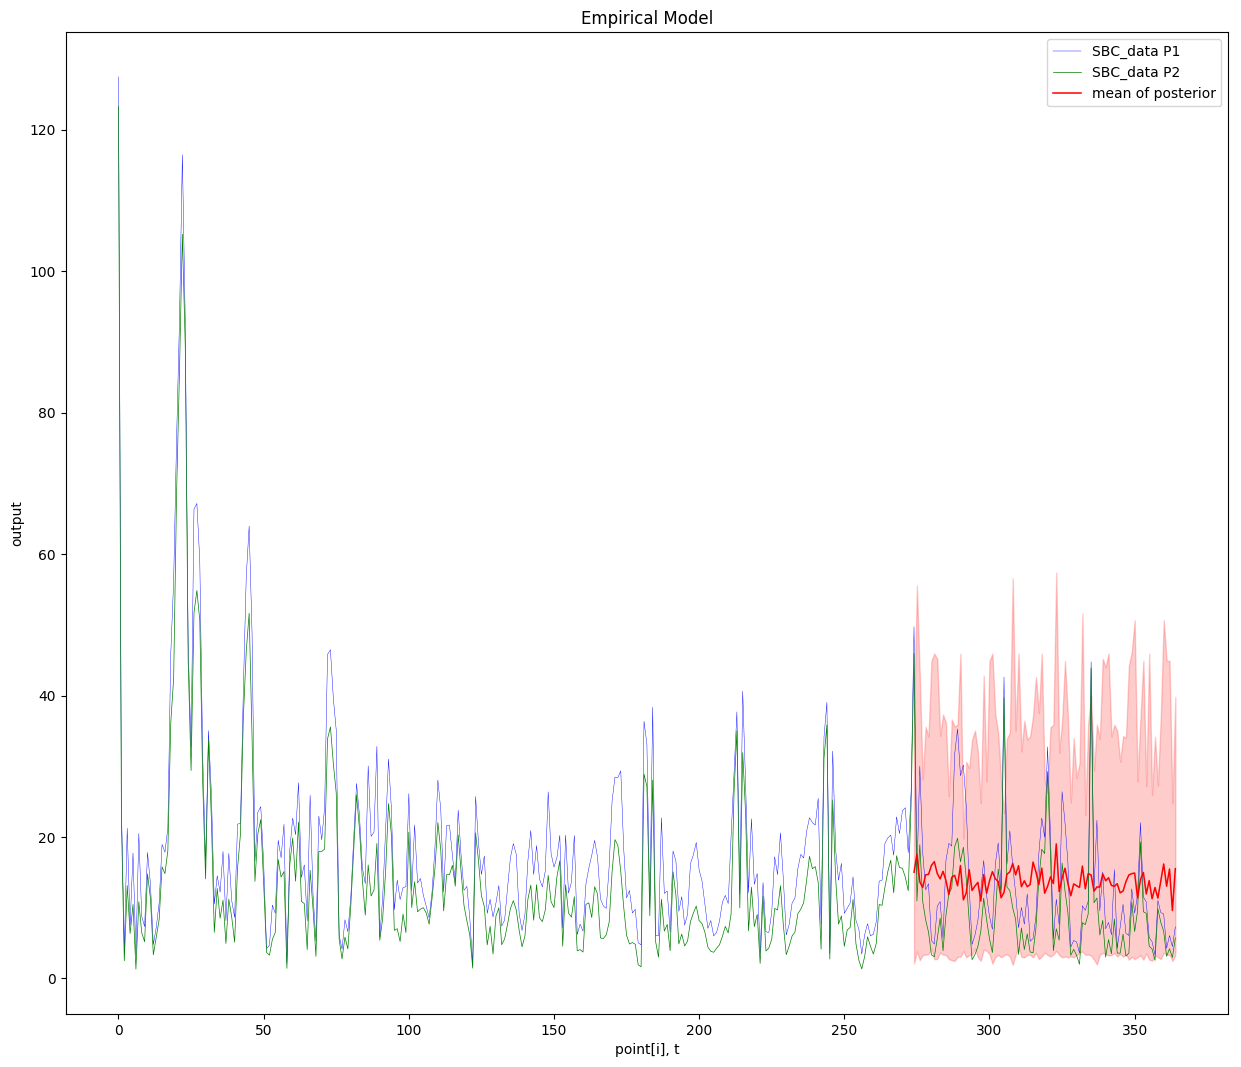

In [86]:
plt.figure(figsize=(15,13), dpi=100)


plt.title("Empirical Model")
plt.xlabel("point[i], t")
plt.ylabel("output")
    
plt.plot(np.arange(y_SBC_1D_P1.shape[0]) ,y_SBC_1D_P1, '-b' , linewidth=0.3,label='SBC_data P1')
plt.plot(np.arange(y_SBC_1D_P2.shape[0]) ,y_SBC_1D_P2, '-g' , linewidth=0.5,label='SBC_data P2')

plt.plot(np.arange(start_pos, end_pos) ,mus_2 , '-r', linewidth=1.1, label='mean of posterior')
plt.fill_between(np.arange(start_pos, end_pos), np.percentile(res_2, 5, axis=1), np.percentile(res_2, 95, axis=1) , color="red", alpha=0.2)

plt.legend()

In [20]:
l = list([1,2,3,4,5,6,7,8,9,10])

In [21]:
l[0:-4]

[1, 2, 3, 4, 5, 6]

In [19]:
l[-4:]

[7, 8, 9, 10]